In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#%matplotlib notebook
#import matplotlib.pylab as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit

3


In [2]:
# Set up console so we can reattach via terminal ipython later. See:
# https://stackoverflow.com/questions/19479645/using-ipython-console-along-side-ipython-notebook

%qtconsole

# Then do `ipython console --existing` in a terminal to connect and have access to same data!
# But note, do not do CTRL-D in that terminal or it will kill the kernel!

Here I re-wrote `runTest` to use `afwTable.matchXy()` for catalog matching (instead of my own matching).
The resulting numbers are slightly different. The old values were:
    
```
{'ZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack': {'FP': 2, 'FN': 25, 'TP': 25}, 'SZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack_decorr': {'FP': 5, 'FN': 25, 'TP': 25}}
```

In [121]:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=False, skyLimited=True)
res = testObj.runTest(returnSources=True, matchDist=np.sqrt(1.5))
src = res['sources']
del res['sources']
print res

HERE1
HERE3
{'ZOGY': {'FP': 3, 'FN': 23, 'TP': 27}, 'ALstack': {'FP': 1, 'FN': 24, 'TP': 26}, 'SZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack_decorr': {'FP': 3, 'FN': 23, 'TP': 27}}


Do forced phot. now with funcs in diffimTests:

In [86]:
cats = testObj.doForcedPhot(transientsOnly=True)
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats

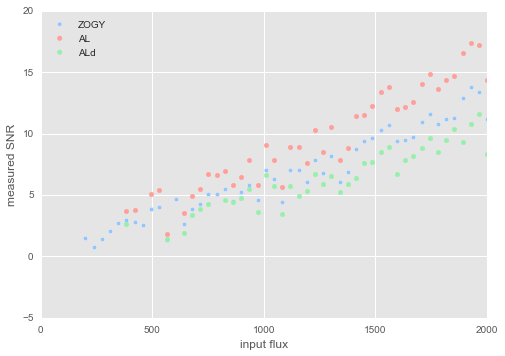

In [87]:
#%matplotlib notebook
plt.scatter(sources['inputFlux_science'], fp_ZOGY['base_PsfFlux_flux']/fp_ZOGY['base_PsfFlux_fluxSigma'], label='ZOGY')
plt.scatter(sources['inputFlux_science'], fp_AL['base_PsfFlux_flux']/fp_AL['base_PsfFlux_fluxSigma'], label='AL', color='r')
plt.scatter(sources['inputFlux_science'], fp_ALd['base_PsfFlux_flux']/fp_ALd['base_PsfFlux_fluxSigma'], label='ALd', color='g')
plt.legend(loc='upper left')
plt.xlabel('input flux')
plt.ylabel('measured SNR')
plt.xlim(0, 2000);

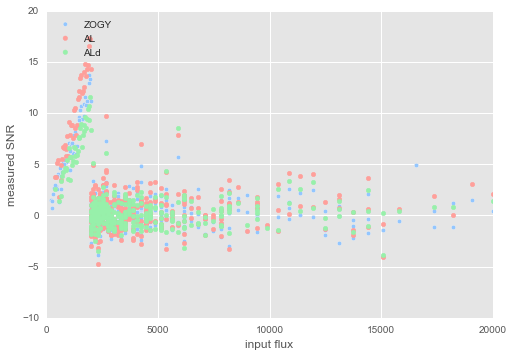

In [88]:
cats = testObj.doForcedPhot(transientsOnly=False)
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats
#%matplotlib notebook
plt.scatter(sources['inputFlux_science'], fp_ZOGY['base_PsfFlux_flux']/fp_ZOGY['base_PsfFlux_fluxSigma'], label='ZOGY')
plt.scatter(sources['inputFlux_science'], fp_AL['base_PsfFlux_flux']/fp_AL['base_PsfFlux_fluxSigma'], label='AL', color='r')
plt.scatter(sources['inputFlux_science'], fp_ALd['base_PsfFlux_flux']/fp_ALd['base_PsfFlux_fluxSigma'], label='ALd', color='g')
plt.legend(loc='upper left')
plt.xlabel('input flux')
plt.ylabel('measured SNR')
plt.xlim(0, 20000);

Try to compute SNR directly using (a) source flux, (b) background variance, and (c) PSF...

In [89]:
flux = 750.
psf = testObj.im2.psf
sky = testObj.im2.sig**2
print sky

nPix = np.sum(psf/psf.max()) * 2.  # not sure where the 2 comes from but it works.
print nPix, np.pi*1.8*2.2*4  # and it equals pi*r1*r2*4.

def snr(flux, sky, psf, skyLimited=True):
    psf = psf / psf.max()
    nPix = np.sum(psf) * 2.
    if skyLimited:  #  only sky noise matters 
        return flux / (np.sqrt(nPix * sky))
    else:
        return flux / (np.sqrt(flux + nPix * sky))

print snr(flux, sky, psf)
print testObj.im2.calcSNR(flux, skyLimited=True)  # moved the func here.

299.99489628
49.7628276329 49.7628276329
6.13835222793
6.13835222793


1.01456190812


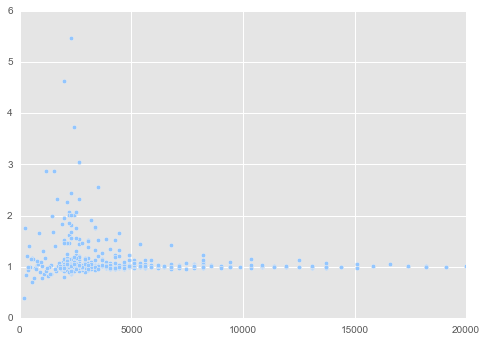

In [90]:
meas = fp2['base_PsfFlux_flux']/fp2['base_PsfFlux_fluxSigma']
calc = testObj.im2.calcSNR(sources['inputFlux_science'], skyLimited=True)
print np.median(meas/calc)
plt.scatter(sources['inputFlux_science'], meas/calc)
plt.xlim(0, 20000);

Figure out matching. Match sources detected in ZOGY diffim to input transients.

In [91]:
cats = testObj.doForcedPhot(transientsOnly=True)
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats
dit.sizeme(dit.catalogToDF(sources).head())

,centroid_x,centroid_y,coord_dec,coord_ra,id,inputFlux_science,inputFlux_template,parent
0,190.250055,268.522124,0.928081,3.761632,1,1853.061224,0.0,0
1,433.697910,382.514098,0.927976,3.761995,2,751.020408,0.0,0
2,139.374588,229.931702,0.928116,3.761556,3,1559.183673,0.0,0
3,139.514874,217.867398,0.928126,3.761556,4,1485.714286,0.0,0
4,462.770744,506.683469,0.927865,3.762039,5,200.000000,0.0,0


Cross-reference the *detections* in ZOGY (`src['ZOGY']`) with the input sources `sources` to identify which of the 50 input transients were detected.

In [92]:
import lsst.afw.table as afwTable
import lsst.afw.table.catalogMatches as catMatch
import lsst.daf.base as dafBase
reload(dit)

matches = afwTable.matchXy(sources, src['ZOGY'], 1.0)
print len(matches)

metadata = dafBase.PropertyList()
matchCat = catMatch.matchesToCatalog(matches, metadata)
tmp = dit.catalogToDF(matchCat)
dit.sizeme(tmp.head())

26


,distance,ref_centroid_x,ref_centroid_y,ref_coord_dec,ref_coord_ra,ref_id,ref_inputFlux_science,ref_inputFlux_template,ref_parent,src_base_CircularApertureFlux_12_0_flag,src_base_CircularApertureFlux_12_0_flag_apertureTruncated,src_base_CircularApertureFlux_12_0_flux,src_base_CircularApertureFlux_12_0_fluxSigma,src_base_CircularApertureFlux_17_0_flag,src_base_CircularApertureFlux_17_0_flag_apertureTruncated,src_base_CircularApertureFlux_17_0_flux,src_base_CircularApertureFlux_17_0_fluxSigma,src_base_CircularApertureFlux_25_0_flag,src_base_CircularApertureFlux_25_0_flag_apertureTruncated,src_base_CircularApertureFlux_25_0_flux,src_base_CircularApertureFlux_25_0_fluxSigma,src_base_CircularApertureFlux_35_0_flag,src_base_CircularApertureFlux_35_0_flag_apertureTruncated,src_base_CircularApertureFlux_35_0_flux,src_base_CircularApertureFlux_35_0_fluxSigma,src_base_CircularApertureFlux_3_0_flag,src_base_CircularApertureFlux_3_0_flag_apertureTruncated,src_base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_3_0_flux,src_base_CircularApertureFlux_3_0_fluxSigma,src_base_CircularApertureFlux_4_5_flag,src_base_CircularApertureFlux_4_5_flag_apertureTruncated,src_base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_4_5_flux,src_base_CircularApertureFlux_4_5_fluxSigma,src_base_CircularApertureFlux_50_0_flag,src_base_CircularApertureFlux_50_0_flag_apertureTruncated,src_base_CircularApertureFlux_50_0_flux,src_base_CircularApertureFlux_50_0_fluxSigma,src_base_CircularApertureFlux_6_0_flag,src_base_CircularApertureFlux_6_0_flag_apertureTruncated,src_base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_6_0_flux,src_base_CircularApertureFlux_6_0_fluxSigma,src_base_CircularApertureFlux_70_0_flag,src_base_CircularApertureFlux_70_0_flag_apertureTruncated,src_base_CircularApertureFlux_70_0_flux,src_base_CircularApertureFlux_70_0_fluxSigma,src_base_CircularApertureFlux_9_0_flag,src_base_CircularApertureFlux_9_0_flag_apertureTruncated,src_base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_9_0_flux,src_base_CircularApertureFlux_9_0_fluxSigma,src_base_GaussianCentroid_flag,src_base_GaussianCentroid_flag_noPeak,src_base_GaussianCentroid_flag_resetToPeak,src_base_GaussianCentroid_x,src_base_GaussianCentroid_y,src_base_GaussianFlux_flag,src_base_GaussianFlux_flux,src_base_GaussianFlux_fluxSigma,src_base_NaiveCentroid_flag,src_base_NaiveCentroid_flag_edge,src_base_NaiveCentroid_flag_noCounts,src_base_NaiveCentroid_flag_resetToPeak,src_base_NaiveCentroid_x,src_base_NaiveCentroid_y,src_base_PeakCentroid_flag,src_base_PeakCentroid_x,src_base_PeakCentroid_y,src_base_PeakLikelihoodFlux_flag,src_base_PeakLikelihoodFlux_flux,src_base_PeakLikelihoodFlux_fluxSigma,src_base_PixelFlags_flag,src_base_PixelFlags_flag_bad,src_base_PixelFlags_flag_cr,src_base_PixelFlags_flag_crCenter,src_base_PixelFlags_flag_edge,src_base_PixelFlags_flag_interpolated,src_base_PixelFlags_flag_interpolatedCenter,src_base_PixelFlags_flag_offimage,src_base_PixelFlags_flag_saturated,src_base_PixelFlags_flag_saturatedCenter,src_base_PixelFlags_flag_suspect,src_base_PixelFlags_flag_suspectCenter,src_base_PsfFlux_flag,src_base_PsfFlux_flag_edge,src_base_PsfFlux_flag_noGoodPixels,src_base_PsfFlux_flux,src_base_PsfFlux_fluxSigma,src_base_SdssCentroid_flag,src_base_SdssCentroid_flag_almostNoSecondDerivative,src_base_SdssCentroid_flag_edge,src_base_SdssCentroid_flag_noSecondDerivative,src_base_SdssCentroid_flag_notAtMaximum,src_base_SdssCentroid_flag_resetToPeak,src_base_SdssCentroid_x,src_base_SdssCentroid_xSigma,src_base_SdssCentroid_y,src_base_SdssCentroid_ySigma,src_base_SdssShape_flag,src_base_SdssShape_flag_maxIter,src_base_SdssShape_flag_psf,src_base_SdssShape_flag_shift,src_base_SdssShape_flag_unweighted,src_base_SdssShape_flag_unweightedBad,src_base_SdssShape_flux,src_base_SdssShape_fluxSigma,src_base_SdssShape_flux_xx_Cov,src_base_SdssShape_flux_xy_Cov,src_base_Sds

OK, we can cross-ref the `ref_id` of `matchesCat` with `id` of `sources`.

In [93]:
dit.sizeme(tmp[np.in1d(tmp['ref_id'], [1,2,3,4,5])])

,distance,ref_centroid_x,ref_centroid_y,ref_coord_dec,ref_coord_ra,ref_id,ref_inputFlux_science,ref_inputFlux_template,ref_parent,src_base_CircularApertureFlux_12_0_flag,src_base_CircularApertureFlux_12_0_flag_apertureTruncated,src_base_CircularApertureFlux_12_0_flux,src_base_CircularApertureFlux_12_0_fluxSigma,src_base_CircularApertureFlux_17_0_flag,src_base_CircularApertureFlux_17_0_flag_apertureTruncated,src_base_CircularApertureFlux_17_0_flux,src_base_CircularApertureFlux_17_0_fluxSigma,src_base_CircularApertureFlux_25_0_flag,src_base_CircularApertureFlux_25_0_flag_apertureTruncated,src_base_CircularApertureFlux_25_0_flux,src_base_CircularApertureFlux_25_0_fluxSigma,src_base_CircularApertureFlux_35_0_flag,src_base_CircularApertureFlux_35_0_flag_apertureTruncated,src_base_CircularApertureFlux_35_0_flux,src_base_CircularApertureFlux_35_0_fluxSigma,src_base_CircularApertureFlux_3_0_flag,src_base_CircularApertureFlux_3_0_flag_apertureTruncated,src_base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_3_0_flux,src_base_CircularApertureFlux_3_0_fluxSigma,src_base_CircularApertureFlux_4_5_flag,src_base_CircularApertureFlux_4_5_flag_apertureTruncated,src_base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_4_5_flux,src_base_CircularApertureFlux_4_5_fluxSigma,src_base_CircularApertureFlux_50_0_flag,src_base_CircularApertureFlux_50_0_flag_apertureTruncated,src_base_CircularApertureFlux_50_0_flux,src_base_CircularApertureFlux_50_0_fluxSigma,src_base_CircularApertureFlux_6_0_flag,src_base_CircularApertureFlux_6_0_flag_apertureTruncated,src_base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_6_0_flux,src_base_CircularApertureFlux_6_0_fluxSigma,src_base_CircularApertureFlux_70_0_flag,src_base_CircularApertureFlux_70_0_flag_apertureTruncated,src_base_CircularApertureFlux_70_0_flux,src_base_CircularApertureFlux_70_0_fluxSigma,src_base_CircularApertureFlux_9_0_flag,src_base_CircularApertureFlux_9_0_flag_apertureTruncated,src_base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_9_0_flux,src_base_CircularApertureFlux_9_0_fluxSigma,src_base_GaussianCentroid_flag,src_base_GaussianCentroid_flag_noPeak,src_base_GaussianCentroid_flag_resetToPeak,src_base_GaussianCentroid_x,src_base_GaussianCentroid_y,src_base_GaussianFlux_flag,src_base_GaussianFlux_flux,src_base_GaussianFlux_fluxSigma,src_base_NaiveCentroid_flag,src_base_NaiveCentroid_flag_edge,src_base_NaiveCentroid_flag_noCounts,src_base_NaiveCentroid_flag_resetToPeak,src_base_NaiveCentroid_x,src_base_NaiveCentroid_y,src_base_PeakCentroid_flag,src_base_PeakCentroid_x,src_base_PeakCentroid_y,src_base_PeakLikelihoodFlux_flag,src_base_PeakLikelihoodFlux_flux,src_base_PeakLikelihoodFlux_fluxSigma,src_base_PixelFlags_flag,src_base_PixelFlags_flag_bad,src_base_PixelFlags_flag_cr,src_base_PixelFlags_flag_crCenter,src_base_PixelFlags_flag_edge,src_base_PixelFlags_flag_interpolated,src_base_PixelFlags_flag_interpolatedCenter,src_base_PixelFlags_flag_offimage,src_base_PixelFlags_flag_saturated,src_base_PixelFlags_flag_saturatedCenter,src_base_PixelFlags_flag_suspect,src_base_PixelFlags_flag_suspectCenter,src_base_PsfFlux_flag,src_base_PsfFlux_flag_edge,src_base_PsfFlux_flag_noGoodPixels,src_base_PsfFlux_flux,src_base_PsfFlux_fluxSigma,src_base_SdssCentroid_flag,src_base_SdssCentroid_flag_almostNoSecondDerivative,src_base_SdssCentroid_flag_edge,src_base_SdssCentroid_flag_noSecondDerivative,src_base_SdssCentroid_flag_notAtMaximum,src_base_SdssCentroid_flag_resetToPeak,src_base_SdssCentroid_x,src_base_SdssCentroid_xSigma,src_base_SdssCentroid_y,src_base_SdssCentroid_ySigma,src_base_SdssShape_flag,src_base_SdssShape_flag_maxIter,src_base_SdssShape_flag_psf,src_base_SdssShape_flag_shift,src_base_SdssShape_flag_unweighted,src_base_SdssShape_flag_unweightedBad,src_base_SdssShape_flux,src_base_SdssShape_fluxSigma,src_base_SdssShape_flux_xx_Cov,src_base_SdssShape_flux_xy_Cov,src_base_Sds

In [146]:
def plotWithDetectionsHighlighted(testObj, transientsOnly=True, addPresub=False, 
                                  xaxisIsScienceForcedPhot=False, alpha=0.5):
    
    #fp_DIFFIM=fp_ZOGY, label='ZOGY', color='b', alpha=1.0,
    
    res = testObj.runTest(returnSources=True, matchDist=np.sqrt(1.5))
    src = res['sources']
    del res['sources']
    print res
    
    cats = testObj.doForcedPhot(transientsOnly=transientsOnly)
    sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats

    # if xaxisIsScienceForcedPhot is True, then don't use sources['inputFlux_science'] --
    #    use fp2['base_PsfFlux_flux'] instead.
    if not xaxisIsScienceForcedPhot:
        srces = sources['inputFlux_science']
    else:
        srces = fp2['base_PsfFlux_flux']
        
    df = pd.DataFrame()
    df['inputFlux'] = sources['inputFlux_science']
    df['templateFlux'] = fp1['base_PsfFlux_flux']
    df['scienceFlux'] = fp2['base_PsfFlux_flux']
    df['inputId'] = sources['id']
    df['inputCentroid_x'] = sources['centroid_x']
    df['inputCentroid_y'] = sources['centroid_y']
    
    fp_DIFFIM = [fp_ZOGY, fp_AL, fp_ALd]
    label = ['ZOGY', 'ALstack', 'ALstack_decorr']
    color = ['b', 'r', 'g']
    
    for i, fp_d in enumerate(fp_DIFFIM):
        df[label[i] + '_SNR'] = fp_d['base_PsfFlux_flux']/fp_d['base_PsfFlux_fluxSigma']

        plt.scatter(srces, 
                    fp_d['base_PsfFlux_flux']/fp_d['base_PsfFlux_fluxSigma'], 
                    color=color[i], alpha=alpha, label=None, s=10)
        plt.scatter(srces, 
                    fp_d['base_PsfFlux_flux']/fp_d['base_PsfFlux_fluxSigma'], 
                    color='k', marker='x', alpha=alpha, label=None, s=10)

        if not xaxisIsScienceForcedPhot:
            matches = afwTable.matchXy(sources, src[label[i]], 1.0)
            metadata = dafBase.PropertyList()
            matchCat = catMatch.matchesToCatalog(matches, metadata)
            sources_detected = dit.catalogToDF(sources)
            detected = np.in1d(sources_detected['id'], matchCat['ref_id'])
            sources_detected = sources_detected[detected]
            sources_detected = sources_detected['inputFlux_science']
            fp_ZOGY_detected = dit.catalogToDF(fp_d)
            detected = np.in1d(fp_ZOGY_detected['id'], matchCat['ref_id'])
            fp_ZOGY_detected = fp_ZOGY_detected[detected]
        else:
            matches = afwTable.matchXy(fp2, src[label[i]], 1.0)
            metadata = dafBase.PropertyList()
            matchCat = catMatch.matchesToCatalog(matches, metadata)
            sources_detected = dit.catalogToDF(fp2)
            detected = np.in1d(sources_detected['id'], matchCat['ref_id'])
            sources_detected = sources_detected[detected]
            sources_detected = sources_detected['base_PsfFlux_flux']
            fp_ZOGY_detected = dit.catalogToDF(fp_d)
            detected = np.in1d(fp_ZOGY_detected['id'], matchCat['ref_id'])
            fp_ZOGY_detected = fp_ZOGY_detected[detected]

        df[label[i] + '_detected'] = detected
        plt.scatter(sources_detected, 
                    fp_ZOGY_detected['base_PsfFlux_flux']/fp_ZOGY_detected['base_PsfFlux_fluxSigma'], 
                    label=label[i], s=20, color=color[i], alpha=alpha) #, edgecolors='r')
    
    if addPresub: # Add measurements in original science and template images
        df['templateSNR'] = fp1['base_PsfFlux_flux']/fp1['base_PsfFlux_fluxSigma']
        plt.scatter(srces, 
                    fp1['base_PsfFlux_flux']/fp1['base_PsfFlux_fluxSigma'], 
                    label='template', color='y', alpha=alpha)
        df['scienceSNR'] = fp2['base_PsfFlux_flux']/fp2['base_PsfFlux_fluxSigma']
        plt.scatter(srces, 
                    fp2['base_PsfFlux_flux']/fp2['base_PsfFlux_fluxSigma'], 
                    label='science', color='orange', alpha=alpha-0.2)
        
    snrCalced = testObj.im2.calcSNR(sources['inputFlux_science'], skyLimited=True)
    df['inputSNR'] = snrCalced
    plt.scatter(srces, snrCalced, color='k', alpha=alpha-0.2, s=7, label='Input SNR')
    plt.scatter([10000], [10], color='k', marker='x', label='Missed')
    plt.legend(loc='upper left', scatterpoints=3)
    if not xaxisIsScienceForcedPhot:
        plt.xlabel('input flux')
    else:
        plt.xlabel('science flux (measured)')
    plt.ylabel('measured SNR')

    return df

In [159]:
## Just re-create the testObj here:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=False, skyLimited=True)

{'ZOGY': {'FP': 3, 'FN': 23, 'TP': 27}, 'ALstack': {'FP': 1, 'FN': 24, 'TP': 26}, 'SZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack_decorr': {'FP': 3, 'FN': 23, 'TP': 27}}


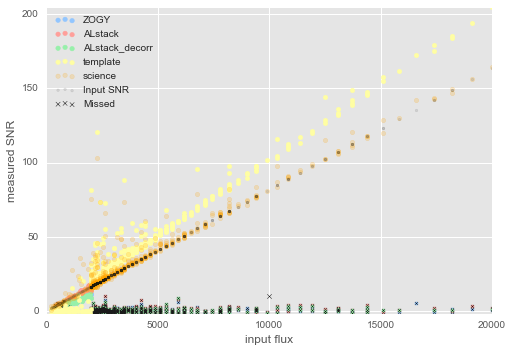

In [128]:
plotWithDetectionsHighlighted(testObj, transientsOnly=False, addPresub=True)
plt.xlim(0, 20010)
plt.ylim(-2, 205);

{'ZOGY': {'FP': 3, 'FN': 23, 'TP': 27}, 'ALstack': {'FP': 1, 'FN': 24, 'TP': 26}, 'SZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack_decorr': {'FP': 3, 'FN': 23, 'TP': 27}}


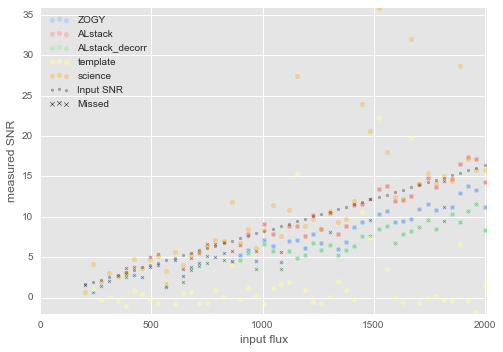

In [160]:
#%matplotlib notebook
df = plotWithDetectionsHighlighted(testObj, transientsOnly=True, addPresub=True)
plt.xlim(0, 2010)
plt.ylim(-2, 36);

Take a look at the apparently "anomalous" points...

In [162]:
tmp = df.ix[(df.scienceSNR > 25) & (df.scienceSNR < 35)]
dit.sizeme(tmp)

,inputFlux,templateFlux,scienceFlux,inputId,inputCentroid_x,inputCentroid_y,ZOGY_SNR,ZOGY_detected,ALstack_SNR,ALstack_detected,ALstack_decorr_SNR,ALstack_decorr_detected,templateSNR,scienceSNR,inputSNR
13,1889.795918,643.932719,3503.389068,14,266.784227,197.655021,12.902151,True,16.551131,True,9.327510,True,6.629525,28.675606,15.466977
14,1669.387755,1949.604984,3900.986177,15,358.110947,235.359902,9.703736,True,12.605479,True,8.201117,True,19.773320,32.073936,13.663053
43,1155.102041,1496.214413,3357.085113,44,415.672128,320.318325,7.071165,True,8.870759,True,4.933336,True,15.242275,27.419440,9.453898


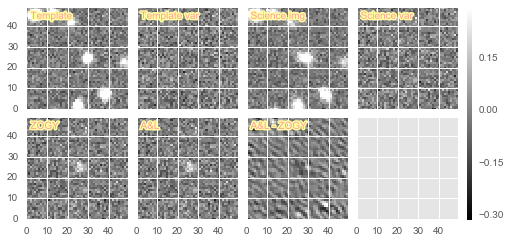

In [163]:
testObj.doPlot(centroidCoord=[tmp.inputCentroid_y.values[0], tmp.inputCentroid_x.values[0]])

In [164]:
tmp = df.ix[(df.templateSNR > 20) & (df.templateSNR < 30)]
dit.sizeme(tmp)

,inputFlux,templateFlux,scienceFlux,inputId,inputCentroid_x,inputCentroid_y,ZOGY_SNR,ZOGY_detected,ALstack_SNR,ALstack_detected,ALstack_decorr_SNR,ALstack_decorr_detected,templateSNR,scienceSNR,inputSNR
42,1522.44898,2189.289178,4377.640234,43,364.102028,308.283394,10.333114,True,13.404467,True,8.522871,True,22.285708,35.91157,12.460437


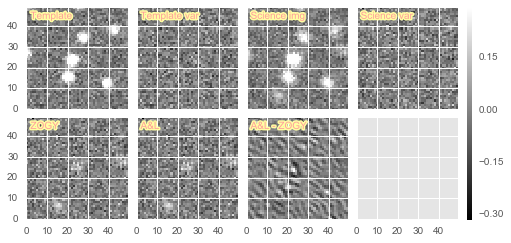

In [165]:
testObj.doPlot(centroidCoord=[tmp.inputCentroid_y.values[0], tmp.inputCentroid_x.values[0]])

{'ZOGY': {'FP': 3, 'FN': 23, 'TP': 27}, 'ALstack': {'FP': 1, 'FN': 24, 'TP': 26}, 'SZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack_decorr': {'FP': 3, 'FN': 23, 'TP': 27}}


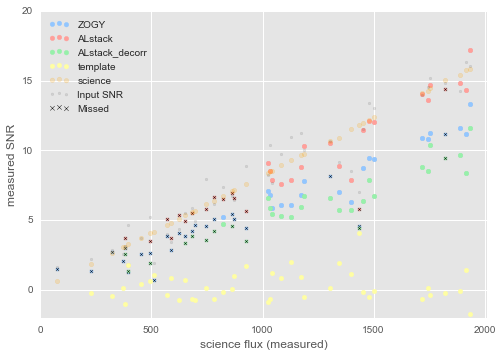

In [113]:
#%matplotlib notebook
plotWithDetectionsHighlighted(testObj, transientsOnly=True, addPresub=True,
                              xaxisIsScienceForcedPhot=True)
plt.xlim(0, 2010)
plt.ylim(-2, 20);

Re-do with all ~5-sigma sources, and no static sources. Just for fun.

That would be transient fluxes of ~750 if `templateNoNoise=False` or ~650 if it's `True`.

In [114]:
reload(dit)
testObj2 = dit.DiffimTest(n_sources=100, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.repeat(750., 50),
                         templateNoNoise=True, skyLimited=True)

{'ZOGY': {'FP': 1, 'FN': 21, 'TP': 29}, 'ALstack': {'FP': 1, 'FN': 25, 'TP': 25}, 'SZOGY': {'FP': 8, 'FN': 26, 'TP': 24}, 'ALstack_decorr': {'FP': 1, 'FN': 27, 'TP': 23}}


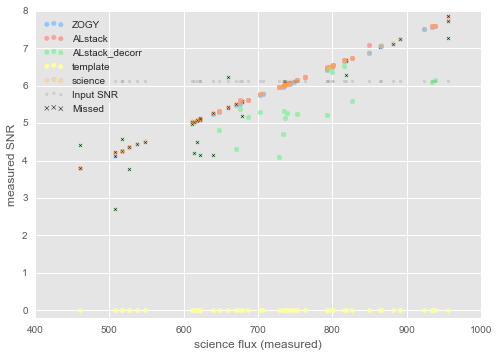

In [117]:
plotWithDetectionsHighlighted(testObj2, transientsOnly=True, addPresub=True,
                              xaxisIsScienceForcedPhot=True)
plt.xlim(400, 1000)
plt.ylim(-0.2, 8);

In [28]:
print testObj2.im1.sig, testObj2.im2.sig
print dit.computeClippedImageStats(testObj2.im1.var)
print dit.computeClippedImageStats(testObj2.im1.im)

1.40509724532 17.3191293692
(1.9742982688012627, 1.3696919938357235, 0.0, 11.0)
(0.92669893807086046, 14.244056830985951, 0.0, 1128.1695855694411)


Try it with `templateNoNoise=False` to see if `ALstack_decorr` works correctly in this case.

In [129]:
reload(dit)
testObj3 = dit.DiffimTest(n_sources=100, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.repeat(750., 50),
                         templateNoNoise=False, skyLimited=False)

{'ZOGY': {'FP': 5, 'FN': 39, 'TP': 11}, 'ALstack': {'FP': 2, 'FN': 45, 'TP': 5}, 'SZOGY': {'FP': 5, 'FN': 40, 'TP': 10}, 'ALstack_decorr': {'FP': 4, 'FN': 40, 'TP': 10}}


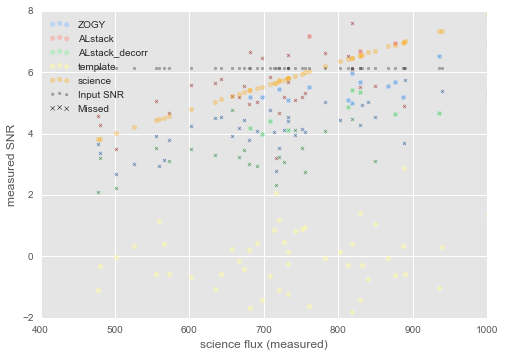

In [134]:
plotWithDetectionsHighlighted(testObj3, transientsOnly=True, addPresub=True,
                                  xaxisIsScienceForcedPhot=True)
plt.xlim(400, 1000)
plt.ylim(-2, 8);

## New topic: double gaussian psf...

1.0


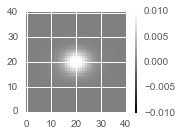

In [74]:
reload(dit)
psfSize = 21
x = np.arange(-psfSize+1, psfSize, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
psf = dit.doubleGaussian2d(x0, y0, 0, 0, a=0.7, sigma_x1=3.0, sigma_y1=3.5, theta1=0.,
                          sigma_x2=5.5, sigma_y2=7.5, theta2=0.)
print psf.sum()
dit.plotImageGrid((psf,), clim=(-0.01, 0.01))

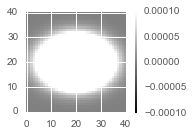

In [75]:
dit.plotImageGrid((psf,), clim=(-0.0001, 0.0001))

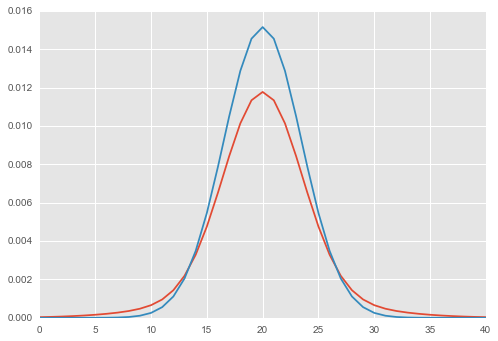

In [76]:
psf2 = dit.singleGaussian2d(x0, y0, 0, 0, sigma_x=3.0, sigma_y=3.5, theta=0.)
plt.plot(psf[20,:])
plt.plot(psf2[20,:])